**Date** 23/11/2025
**Author** Jordi Torres
Core code based on work by professor Gaillard. 

**EXERCISE 1** Ayagari + employment status

In [1]:
#libraries 

using Printf;
using Roots;
using Plots;
using Distributions;

#wider page display
display("text/html", "<style>.container { width:100% !important; }</style>")

**Variables fixed**

In [2]:
const size_k 	= 1000;    #number of grid points     
const size_m 	= 7;       #number of productivity classes

const size_e =2 ; #added!

const kmin 		= 0.0;
const kmax 		= 1700.0;

betapar 	= 0.96;
const alphapar 	= 0.36;
const deltapar 	= 0.08;
const rhopar 	= 3.0;
const labor 	= 1.0219882;

const epsV    = 1.0e-6
const epsdist = 1.0e-8
const epsK    = 1.0e-6   # for debugging


## grid constants
const scale1 = 1.6;
const grmin = (kmin/scale1)-1.0;
const exponen=log((kmax/scale1)-grmin)/(size_k-1);

const sstates = [exp(-0.600000000000000)	  exp(-0.400000000000000)	  exp(-0.200000000000000)	  exp(0.000000000000000)	   exp(0.200000000000000)	   exp(0.400000000000000)	   exp(0.600000000000000)];

const strans = [	
    0.046746218637144	   0.217937777267117	   0.397822606398702	   0.266386738072197	   0.065169922261456	   0.005754191945237	   0.000182545418147;	
	0.023199661746751	   0.149524091076020	   0.369020347246402	   0.333823905199677	   0.110578117872631	   0.013276146769082	   0.000577730089437;	
	0.010548958644399	   0.093657511915497	   0.312761268311836	   0.382193227897354	   0.171253064028981	   0.027919224002876	   0.001666745199056;	
	0.004387354018187	   0.053538402796357	   0.242163972572887	   0.399820541225137	   0.242163972572887	   0.053538402796357	   0.004387354018187;	
	0.001666745199056	   0.027919224002876	   0.171253064028981	   0.382193227897354	   0.312761268311837	   0.093657511915497	   0.010548958644399;	
	0.000577730089436	   0.013276146769082	   0.110578117872631	   0.333823905199677	   0.369020347246403	   0.149524091076020	   0.023199661746751;	
	0.000182545418147	   0.005754191945237	   0.065169922261456	   0.266386738072197	   0.397822606398702	   0.217937777267117	   0.046746218637144];

#extension:

 b= 0.35
 tau_wage=0.25

const etrans = [
    0.45 0.55
    0.04 0.96
]

emplo = [0.0, 1.0]


2-element Vector{Float64}:
 0.0
 1.0

**Utility**

In [3]:
function utility(cons::Float64)
    cons_adj = max(cons, 1.0e-8)      
    return (cons_adj^(1.0-rhopar)) / (1.0 - rhopar)
end


function invmargutil(x::Float64)
    x_adj = max(x, 1.0e-12)     # ensure strictly positive
    return x_adj^(-1.0/rhopar)
end


invmargutil (generic function with 1 method)

**Grid Manipulation functions**

In [4]:
function inter1d(x1::Float64,y1::Float64,y2::Float64) 
    return ((1.0-(x1))*(y1)+(x1)*(y2))
end

function getwage(rrate::Float64)
    return (1.0-alphapar)*(alphapar/(rrate+deltapar))^(alphapar/(1.0-alphapar));
end

function getlevel(igrid::Int64)
    #careful this function assumes that grid starts at 0
    return ( scale1*(exp(exponen*(igrid))+grmin) );
end

function getgrid(x::Float64)
    #careful because indexes start at 1 in Julia, a +1.0 was added
    return (log((x)/scale1-grmin)/exponen)+1.0;
end

getgrid (generic function with 1 method)

**EGM derivative**

In [5]:
function nderiv(val1::Float64,val2::Float64,val3::Float64,x1::Float64,x2::Float64,x3::Float64) 
    return ((1.0 - (x3 - x2)/(x3 - x1))*((val3 - val2)/(x3-x2)) + ((x3 - x2)/(x3 - x1))*((val2 - val1)/(x2-x1)));
end

nderiv (generic function with 1 method)

In [6]:
function POLICY_we(valueF::Array{Float64,3},dvalueF::Array{Float64,3},save::Array{Float64,3},wagerate::Float64,rrate::Float64, grid::Array{Float64}, betapar::Float64, tau_wage::Float64, b::Float64)

    aendo  = zeros(Float64, size_k, size_m, size_e);
    EVendo = zeros(Float64, size_k, size_m, size_e);  

    iter=0;

    critV=10000.0;

    while critV>epsV

        # we need copy to make a separate object
        valueFnew = copy(valueF);

        # COMPUTE EXPECTED VALUE / DERIVATIVE / ENDOGENEOUS GRID 
      @inbounds for iemplo::Int64 in 1:1:(size_e)  

            @inbounds Threads.@threads  for iprod::Int64 in 1:1:(size_m) #this is the s_t
                @inbounds for igrid::Int64 in 1:1:(size_k) #this is a' or a_t+1
                        
                    #writing the continuation value
                    tempnext  = 0.0;
                    dtempnext = 0.0;
                    @inbounds for iprodnext::Int64 in 1:1:(size_m) #this is the s_t+1
                        @inbounds for iemplonext::Int64 in 1:1:(size_e) #this is the s_t+1

                            ## next period expected value
                            tempnext  += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*valueF[igrid,iprodnext, iemplonext];

                            ## next period derivative 
                            dtempnext += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*dvalueF[igrid,iprodnext, iemplonext];

                            if dtempnext <= 0 || isnan(dtempnext)
                                @printf("ERROR: dtempnext = %e at (igrid=%d, iprod=%d, iemplo=%d)\n",
                                dtempnext, igrid, iprod, iemplo)
                                error("Bad dtempnext")
                            end

                            



                        end 
                    end

                    # computing endogenous grid using the first order condition
                    aendo[igrid,iprod, iemplo]  = (invmargutil(betapar*dtempnext) + grid[igrid] - wagerate * (emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage)* sstates[iprod])/(1.0 + rrate);
                    EVendo[igrid,iprod, iemplo] = tempnext;

                end
            end
       end

        ## aendo[igrid,iprod]  -- endogenous grid of assets 
        ## atilde(a' = 1 , s) , ...,  atilde(a' = a_n , s) 
        
        ## aexo 
        ## grid[1], ... , grid[n]




        @inbounds for iemplo::Int64 in 1:1:(size_e) 

            # RESCALING STEP
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m) #current productivity state
                ilast=1;
                @inbounds for igrid::Int64 in 1:1:(size_k) #current level of assets 
                    
                    # build cohexo for simplicity
                    cohexo = (1.0 + rrate) * grid[igrid] + wagerate * sstates[iprod]*(emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage);


                    # case 1: borrowing constrained case
                    if grid[igrid] <= aendo[1,iprod, iemplo]

                        save[igrid,iprod, iemplo]   = grid[1];
                        evfnext = EVendo[1,iprod, iemplo];

                    else ## otherwise I am either in case 2 or case 3

                        ## This is an improvement because we do not need to restart from scratch (due to monotonicity). 
                        ## We start with the previous grid point solution.
                        itest=ilast;  

                        # case 2: extrapolation case
                        if grid[igrid] > aendo[size_k,iprod, iemplo]
                            ## extrapolation so vfweight > 1
                            vfweight = (grid[igrid]-aendo[size_k-1,iprod, iemplo])/(aendo[size_k,iprod, iemplo]-aendo[size_k-1,iprod, iemplo]);
                            igridL   = size_k-1;
                            igridH   = size_k;
                        else

                            #finding interpolating points on cohendo
                            while ((itest<(size_k+1)&&(grid[igrid]>aendo[itest,iprod, iemplo])))
                                itest+=1;
                            end
                            
                            ## some sanity checks
                            if itest>(size_k+1)
                                @printf("itest>(size_k+1)");
                                exit()
                            end

                            # standard interior case
                            if itest==1
                                @printf("itest==1");
                                exit()
                            end

                            vfweight = (grid[igrid]-aendo[itest-1,iprod, iemplo])/(aendo[itest,iprod, iemplo]-aendo[itest-1,iprod, iemplo]);
                            igridL   = itest-1;
                            igridH   = itest;

                        end

                        ## linear interpolation of the value function and saving function using above weights and indexes
                        evfnext = inter1d(vfweight,EVendo[igridL,iprod, iemplo],EVendo[igridH,iprod, iemplo]);
                        save[igrid,iprod, iemplo] = inter1d(vfweight,grid[igridL],grid[igridH]);                    

                        ilast = min(size_k-1,itest);

                    end

                    ## construct the new VF
                    valueF[igrid,iprod, iemplo] = utility(cohexo-save[igrid,iprod, iemplo]) + betapar * evfnext;

                end
            end
        end 










        # computing new derivatives and convergence
        critV=0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
            
                    # interior deriv
                    if (igrid>=3)
                        dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                    end

                    critV=max(critV,abs(valueF[igrid,iprod, iemplo]-valueFnew[igrid,iprod, iemplo]));

                    # left corner
                    dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);

                    # right corner
                    dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);
        
                end
            end
        end 
        iter+=1;
         #@printf("CNVG %4d\t%20.15f\n",iter,critV);

    end
    

end

POLICY_we (generic function with 1 method)

**Simulation** $\rightarrow$ General Equilibrium!!!

In [7]:
function SIMULATION_we(save::Array{Float64,3},dist::Array{Float64,3},grid::Array{Float64})

    distold = zeros(Float64, size_k, size_m, size_e);

    critdist=1.0;
    while critdist>epsdist

        distold=copy(dist);
        fill!(dist, 0.0);

        @inbounds for iemplo::Int64 in 1:1:(size_e)
        # distribution dynamics
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    if distold[igrid,iprod, iemplo]>0

                        ## find index of saving value on the grid of assets/employment + associated weights
                        isave = min(floor(Int64, getgrid(save[igrid,iprod, iemplo])),size_k-1);
                        weight = (save[igrid,iprod, iemplo]-grid[isave])/(grid[isave+1]-grid[isave]);
                        @inbounds for iemplonext in 1:1:(size_e) 
                        # apply the mass to the new grid points.
                            @inbounds for iprodnext::Int64 in 1:1:(size_m)
                                dist[isave,iprodnext, iemplonext]               += (1.0-weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                                dist[min(isave+1,size_k),iprodnext, iemplonext] += (weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                            end
                        end 

                    end

                end
             end
        end




        # check convergence
        critdist=0.0;
        distverif = 0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    critdist=(max(critdist,abs(dist[igrid,iprod,iemplo]-distold[igrid,iprod, iemplo]))) ;
                    distverif+=dist[igrid,iprod, iemplo];
                end
            end
        end 
        # @printf("SIM %20.15f\t%20.15f\n", critdist, distverif);
    end




    # computing aggregates

    #capital
    capitalout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                capitalout+=dist[igrid,iprod, iemplo]*grid[igrid];
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 
    #Govt budget

  laborout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                laborout+=dist[igrid,iprod, iemplo]*sstates[iprod]*(emplo[iemplo]);
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 

    # println(capitalout);
    # read(stdin, Char);

    return(capitalout, laborout);


end

SIMULATION_we (generic function with 1 method)

In [8]:
    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);

    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




    # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        # @printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end


    # initial prices
    rrate    = 0.040237086402090;
    wagerate = getwage(rrate);


    # GUESS:: initializing value function (inceasing in k) and initial derivative
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = getlevel(igrid-1)
                valueF[igrid, iprod, iemplo] = utility(wagerate*sstates[iprod]*(emplo[iemplo] + b*(1-emplo[iemplo]))*(1-tau_wage) + (1+rrate)*a)
            end
        end
    end

    # GUESS initial distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed

    
    ## COMPUTE derivative
    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)

                # interior deriv
                if (igrid>=3)
                    dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                end

                # left corner
                dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);
                # right corner
                dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);

            end
        end
    end 

    POLICY_we(valueF,dvalueF,save,wagerate,rrate, grid, betapar, tau_wage, b);
            
    capitalout, laborout=SIMULATION_we(save,dist,grid);

Aiyagari1994 using 1 threads


Mass of distribution = 0.9999999999978223
capitalout = 8.389328245154486
laborout = 0.952700858161083
dist I=0.9999999999978222


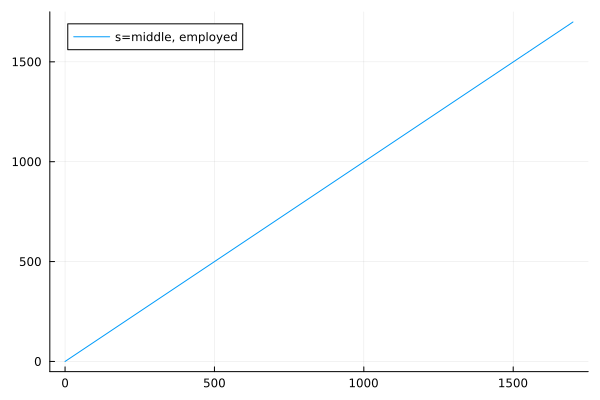

In [9]:
##sanity checks

println("Mass of distribution = ", sum(dist))
println("capitalout = ", capitalout)
println("laborout = ", laborout)

distI = dropdims(sum(dist, dims=(2,3)), dims=(2,3))  # sum over s,e
println("dist I=", sum(distI))

using Plots
plot(grid, save[:, 4, 2], label="s=middle, employed")




**Extend to General equilibrium**

In [10]:
const relaxsK 	= 0.05;


In [11]:
# functions for the equilibrium wage.
function getwage_eq(LABOR::Float64,CAPITAL::Float64)
    return (1.0-alphapar) * getGDP(LABOR,CAPITAL)/LABOR;
end

# function for the equilibrium interest rate. 
function getrate_eq(LABOR::Float64,CAPITAL::Float64)
    return (alphapar) * getGDP(LABOR,CAPITAL)/CAPITAL - deltapar;
end

 # functions for the equilibrium.
function getGDP(LABOR::Float64,CAPITAL::Float64)
    return (LABOR^(1.0-alphapar)) * (CAPITAL^(alphapar));
end

getGDP (generic function with 1 method)

In [12]:

function main_ge(betapar::Float64,impose_budget_balance::Bool, b::Float64)


    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);
    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




 # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        ##@printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end



 # initial prices, gdp!!!
    LABOR   = 0.4
    CAPITAL = 2.60
    gdp= 0
    fixed_tau=0.25
    

    rrate    = getrate_eq(LABOR,CAPITAL);
    wagerate = getwage_eq(LABOR,CAPITAL);

    @printf("%f %f\n",rrate,wagerate);

 # distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed


    # === 1. Initialize value function ===
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = grid[igrid]
                inc = wagerate * sstates[iprod] *
                    (emplo[iemplo] + b*(1-emplo[iemplo])) *
                    (1 - tau_wage)

                valueF[igrid, iprod, iemplo] = utility((1+rrate)*a + inc)
            end
        end
    end

    # === 2. Compute initial derivatives ===
    for iemplo in 1:size_e
        for iprod in 1:size_m

            # left
            dvalueF[1, iprod, iemplo] =
                (valueF[2,iprod,iemplo] - valueF[1,iprod,iemplo])/(grid[2]-grid[1])

            # interior
            for igrid in 3:size_k
                dvalueF[igrid-1, iprod, iemplo] =
                    nderiv(valueF[igrid-2,iprod,iemplo],
                        valueF[igrid-1,iprod,iemplo],
                        valueF[igrid,iprod,iemplo],
                        grid[igrid-2],grid[igrid-1],grid[igrid])
            end

            # right
            dvalueF[size_k, iprod, iemplo] =
                (valueF[size_k,iprod,iemplo] -
                valueF[size_k-1,iprod,iemplo])/(grid[end]-grid[end-1])
        end
    end

   @time begin
    ge_iter = 0
    max_ge_iter = 80

    critK = 1.0

    while critK > epsK && ge_iter < max_ge_iter
        ge_iter += 1

        t_iter_start = time()

        if (betapar*(1.0+rrate)>=1.0)
            println("Beta condition is not respected ",rrate," ",(betapar*(1.0+rrate)));
            exit();
        end



        ### --- TIMER: POLICY STEP ---
        t_policy_start = time()
        POLICY_we(valueF, dvalueF, save, wagerate, rrate, grid, betapar, fixed_tau, b)
        t_policy = time() - t_policy_start


        ### --- TIMER: SIMULATION STEP ---
        t_sim_start = time()
        SIMULATION_we(save, dist, grid)
        t_sim = time() - t_sim_start

        ### --- COMPUTE AGGREGATES ---

        # === GOVERNMENT BUDGET CONSTRAINT ===
            if impose_budget_balance ##This condition is set if we want to impose budget balance. 
                L_emp   = 0.0
                L_unemp = 0.0

                for iemplo in 1:size_e
                    for iprod in 1:size_m
                        for igrid in 1:size_k
                            mass = dist[igrid,iprod,iemplo]
                            s    = sstates[iprod]
                            e    = emplo[iemplo]

                            if e == 1
                                L_emp   += mass * s
                            else
                                L_unemp += mass * s
                            end
                        end
                    end
                end

                fixed_tau = b * L_unemp / L_emp
            end




        capitalnew = 0.0
        labornew   = 0.0

        @inbounds for iemplo::Int in 1:size_e
            @inbounds for iprod::Int in 1:size_m
                @inbounds for igrid::Int in 1:size_k
                    capitalnew += dist[igrid,iprod,iemplo] * grid[igrid]
                    labornew   += dist[igrid,iprod,iemplo] * emplo[iemplo] * sstates[iprod]
                end
            end
        end

        # compute convergence
        wwage0 = wagerate
        rrate0 = rrate
        critK = abs((capitalnew - CAPITAL) / CAPITAL)

        # relaxation update
        CAPITAL = relaxsK * capitalnew + (1.0 - relaxsK) * CAPITAL
        LABOR   = relaxsK * labornew   + (1.0 - relaxsK) * LABOR

        # new prices
        rrate    = getrate_eq(LABOR, CAPITAL)
        wagerate = getwage_eq(LABOR, CAPITAL)
        gdp      = getGDP(LABOR, CAPITAL)



        t_iter = time() - t_iter_start

        ### === PRINT TIMERS AND RESULTS ===
        @printf("GE %3d | critK = %1.6e | t_policy = %4.3f s | t_sim = %4.3f s | t_iter = %4.3f s\n",
                ge_iter, critK, t_policy, t_sim, t_iter)

        @printf("         r=[%5f→%5f],  K=[%5f→%5f],  L=[%5f→%5f],  KY=%5f\n\n",
                rrate0, rrate, CAPITAL, capitalnew, LABOR, labornew, CAPITAL/gdp)

    end
 end



    distI = zeros(Float64, size_k);

    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)
                distI[igrid] += dist[igrid,iprod, iemplo];
            end
        end
    end 


    welfare = 0.0
        for iemplo in 1:size_e
            for iprod in 1:size_m
                for igrid in 1:size_k
                    welfare += dist[igrid, iprod, iemplo] * valueF[igrid, iprod, iemplo]
                end
            end
        end

  return CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau
end



main_ge (generic function with 1 method)

In [13]:
   b_CAPITAL, b_LABOR, b_gdp,  dist, valueF, b_welfare, fixed_tau= main_ge(betapar, false, b);

   ##fixed b, betapar, with the possibility to impose budget balance (if not, also use fixed tau_wage =0.25)

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 1.628614e-01 | t_policy = 1.561 s | t_sim = 0.058 s | t_iter = 1.620 s
         r=[0.028652→0.033993],  K=[2.578828→2.176560],  L=[0.427635→0.952701],  KY=3.158082

GE   2 | critK = 1.000940e-01 | t_policy = 1.037 s | t_sim = 0.117 s | t_iter = 1.154 s
         r=[0.033993→0.038046],  K=[2.591734→2.836953],  L=[0.453888→0.952701],  KY=3.049654

GE   3 | critK = 6.758058e-01 | t_policy = 1.168 s | t_sim = 0.334 s | t_iter = 1.502 s
         r=[0.038046→0.039587],  K=[2.679310→4.343243],  L=[0.478829→0.952701],  KY=3.010365

GE   4 | critK = 1.355146e+00 | t_policy = 0.932 s | t_sim = 0.758 s | t_iter = 1.690 s
         r=[0.039587→0.038273],  K=[2.860853→6.310167],  L=[0.502523→0.952701],  KY=3.043810

GE   5 | critK = 5.829370e-01 | t_policy = 0.916 s | t_sim = 0.462 s | t_iter = 1.379 s
         r=[0.038273→0.039420],  K=[2.944237→4.528549],  L=[0.525031→0.952701],  KY=3.014560

GE   6 | critK = 1.027775e+00 | t_policy = 

(5.317222190318641, 0.9435727965596938, 1.758339751466645, [5.563885248532087e-7 4.832363920074189e-6 … 2.8100977870055812e-6 2.3719111474616515e-7; 8.143923175815191e-8 7.456525708741923e-7 … 5.732632548377888e-7 5.209828911790873e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 7.624984110510397e-7 6.290700529967928e-6 … 3.444715299649003e-6 2.9022229139481033e-7; 1.8651116362219917e-7 1.425998985701308e-6 … 7.388604478361453e-7 6.530086688530179e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-39.20675975281483 -33.06528516702879 … -22.12490992031995 -20.84003951506617; -37.12585691772558 -31.90347537461594 … -21.995608985368495 -20.750675399311657; … ; -0.002803056668653915 -0.0028027773198098507 … -0.0028012503758150335 -0.0028007254256392274; -0.0027646465985468154 -0.0027643728191159766 … -0.0027628762714793182 -0.0027623617554795674;;; -20.15292739250332 -19.220144504375234 … -16.40750906466199 -15.731740695577942; -20.057935725362363 -19.161803354857557 … -16.384682699404454 -1

In [14]:
function check_budget_balance(dist, wage, tau_wage)

    L_emp   = 0.0
    L_unemp = 0.0

    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                mass = dist[igrid, iprod, iemplo]
                s    = sstates[iprod]
                e    = emplo[iemplo]   # 0 or 1

                if e == 1.0
                    L_emp   += mass * s
                else
                    L_unemp += mass * s
                end
            end
        end
    end

    tax_revenue = tau_wage * wage * L_emp
    ui_spending = b * wage * L_unemp

    println("=== Government budget check ===")
    println("  tau_wage       = ", tau_wage)
    println("  L_emp          = ", L_emp)
    println("  L_unemp        = ", L_unemp)
    println("  Tax revenue    = ", tax_revenue)
    println("  UI expenditures= ", ui_spending)
    println("  Diff (T-UI)    = ", tax_revenue - ui_spending)
    println("  Rel diff       = ", (tax_revenue - ui_spending) / max(abs(ui_spending), 1e-12))
end

check_budget_balance(dist, wagerate, fixed_tau)


=== Government budget check ===
  tau_wage       = 0.25
  L_emp          = 0.9527008581549787
  L_unemp        = 0.0692873351385437
  Tax revenue    = 0.28247178288303926
  UI expenditures= 0.028760763348091183
  Diff (T-UI)    = 0.25371101953494807
  Rel diff       = 8.821428571428601


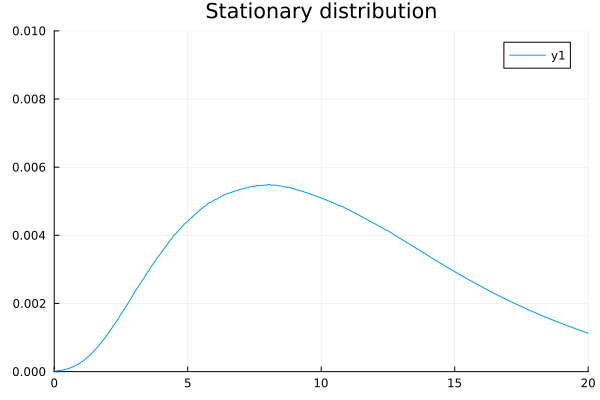

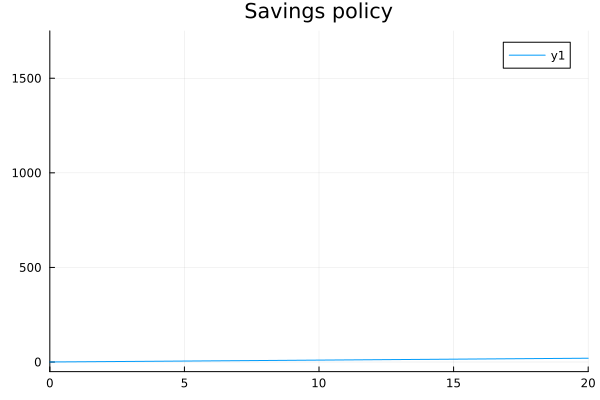

In [15]:
    display(plot(grid, distI, xlimits=(0,20), ylimits=(0,0.01),
                 title="Stationary distribution"))

    display(plot(grid, save[:,ceil(Int,size_m/2),2],
                 xlimits=(0,20), title="Savings policy"))

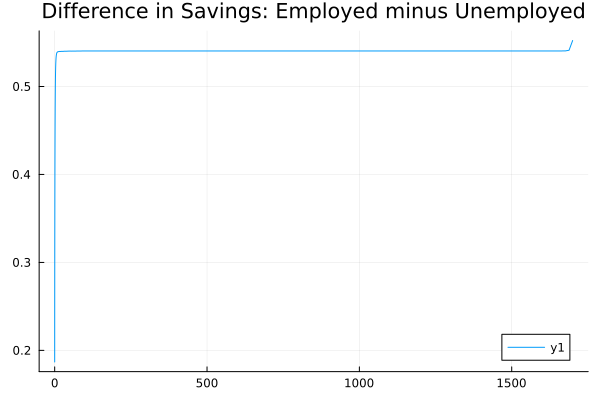

In [16]:
iprod = ceil(Int, size_m/2)

plot(grid, save[:,iprod,2] .- save[:,iprod,1],
    title="Difference in Savings: Employed minus Unemployed")



In [17]:
iprod = ceil(Int, size_m/2)
a = grid[500]

inc_emp   = wagerate * sstates[iprod] * (emplo[2] + b*(1-emplo[2])) * (1 - tau_wage)
inc_unemp = wagerate * sstates[iprod] * (emplo[1] + b*(1-emplo[1])) * (1 - tau_wage)

println("employed income = ", inc_emp)
println("unemployed income = ", inc_unemp)
println("ratio = ", inc_unemp / inc_emp)


employed income = 0.8894873363400143
unemployed income = 0.311320567719005
ratio = 0.35000000000000003


**Exercise 3** Calibrating the beta 

In [18]:
function compute_KY(beta)
    K, L, Y = main_ge(beta, false, b)   # run GE
    return K / Y
end


compute_KY (generic function with 1 method)

In [ ]:
function calibrate_beta(KY_target; β_low = 0.90, β_high = 0.995, tol = 1e-3)

    max_iter = 50
    iter = 0

    while iter < max_iter
        iter += 1
        β_mid = 0.5 * (β_low + β_high)

        KY_mid = compute_KY(β_mid)
        diff = KY_mid - KY_target

        println("iter $iter: β =$β_mid   -> K/Y =$KY_mid   diff = $diff")

        if diff > 0
            β_high = β_mid
        else
            β_low = β_mid
        end

        #convergence check !
        if abs(diff) < tol
            return β_mid
        end
    end

    return betacalibrated=0.5 * (β_low + β_high)
end


calibrate_beta (generic function with 1 method)

In [20]:
beta_calibrated= calibrate_beta(3.2; β_low = 0.90, β_high = 0.995, tol=1e-3)

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 4.262749e-01 | t_policy = 1.081 s | t_sim = 0.029 s | t_iter = 1.111 s
         r=[0.028652→0.034973],  K=[2.544584→1.491685],  L=[0.427635→0.952701],  KY=3.131179

GE   2 | critK = 3.325105e-01 | t_policy = 0.802 s | t_sim = 0.041 s | t_iter = 0.843 s
         r=[0.034973→0.040730],  K=[2.502279→1.698483],  L=[0.453888→0.952701],  KY=2.981862

GE   3 | critK = 1.978014e-01 | t_policy = 0.777 s | t_sim = 0.062 s | t_iter = 0.839 s
         r=[0.040730→0.045732],  K=[2.477532→2.007325],  L=[0.478829→0.952701],  KY=2.863234

GE   4 | critK = 1.238867e-02 | t_policy = 0.750 s | t_sim = 0.105 s | t_iter = 0.855 s
         r=[0.045732→0.049628],  K=[2.479066→2.508225],  L=[0.502523→0.952701],  KY=2.777185

GE   5 | critK = 3.685459e-01 | t_policy = 0.737 s | t_sim = 0.215 s | t_iter = 0.953 s
         r=[0.049628→0.051765],  K=[2.524749→3.392716],  L=[0.525031→0.952701],  KY=2.732128

GE   6 | critK = 8.240760e-01 | t_policy = 

0.9665185546874999

**Exercise 4** Now we basically have to loop over possible values of b and set budget balance so that tau_wage also changes with the loop. 


3. Check welfare is well defined!!  -->this is the most importn
4. Write a loop over b that returns different values of tau_wage (include also as an output of the function)
5. Should we use the calibrated Beta from the previous exercise? should we enforce that-> I will 

In [21]:
function compute_cev(b_welfare, new_welfare, rhopar)

    CVE= (new_welfare/b_welfare)^(1/(1-rhopar))-1
    return CVE
end    

compute_cev (generic function with 1 method)

In [22]:
##This should be quite easy
function simulate_bpaths(b_grid, beta, b_welfare, rhopar)

    simul_results = zeros(length(b_grid), 3)

    @inbounds for igrid in 1:length(b_grid)

        b_simul = b_grid[igrid]

        print("Running b = $b_simul ($igrid/$(length(b_grid)))\n")
        flush(stderr)   
        flush(stdout)   

        CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau= main_ge(beta, true, b_simul)

        CVE= compute_cev(b_welfare, welfare, rhopar)

        simul_results[igrid, 1] = b_simul
        simul_results[igrid, 2] = CVE
        simul_results[igrid, 3] = fixed_tau
    end

    return simul_results
end



simulate_bpaths (generic function with 1 method)

In [25]:
b2_CAPITAL, b2_LABOR, b2_gdp,  dist, valueF, b2_welfare, fixed_tau= main_ge(beta_calibrated, false, b);

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 2.355032e-01 | t_policy = 1.725 s | t_sim = 0.127 s | t_iter = 1.853 s
         r=[0.028652→0.032552],  K=[2.630615→3.212308],  L=[0.427635→0.952701],  KY=3.198525

GE   2 | critK = 1.252095e+00 | t_policy = 1.211 s | t_sim = 0.587 s | t_iter = 1.799 s
         r=[0.032552→0.032470],  K=[2.795304→5.924396],  L=[0.453888→0.952701],  KY=3.200864

GE   3 | critK = 1.069939e+00 | t_policy = 0.739 s | t_sim = 0.331 s | t_iter = 1.071 s
         r=[0.032470→0.032569],  K=[2.944845→5.786110],  L=[0.478829→0.952701],  KY=3.198044

GE   4 | critK = 1.022878e+00 | t_policy = 0.769 s | t_sim = 0.366 s | t_iter = 1.136 s
         r=[0.032569→0.032455],  K=[3.095456→5.957063],  L=[0.502523→0.952701],  KY=3.201284

GE   5 | critK = 8.608496e-01 | t_policy = 0.781 s | t_sim = 0.388 s | t_iter = 1.170 s
         r=[0.032455→0.032576],  K=[3.228692→5.760177],  L=[0.525031→0.952701],  KY=3.197852

GE   6 | critK = 8.490911e-01 | t_policy = 

In [ ]:
##apply function and define grid over b for which to loop over
b_grid = range(0.01, stop=0.6, step=0.05)

b_simul= simulate_bpaths(b_grid, beta_calibrated, b2_welfare, rhopar)

10×3 Matrix{Float64}:
 0.01  0.260156  0.000727273
 0.06  0.259496  0.00436364
 0.11  0.258762  0.008
 0.16  0.257969  0.0116364
 0.21  0.257116  0.0152727
 0.26  0.256196  0.0189091
 0.31  0.255202  0.0225455
 0.36  0.254128  0.0261818
 0.41  0.252986  0.0298182
 0.46  0.251806  0.0334545

In [ ]:
#comparing to baseline with budget balance too (fairest comparison, I would say)->now we are comparing bananas with bananas, citing professor Bobba.

b2_CAPITAL_wa, b2_LABOR_wa, b2_gdp_wa,  dist, valueF, b2_welfare_wa, fixed_tau= main_ge(beta_calibrated, true, b);





In [36]:
##apply function and define grid over b for which to loop over
b_grid = range(0.01, stop=0.6, step=0.03)

b_simul_2= simulate_bpaths(b_grid, beta_calibrated, b2_welfare_wa, rhopar)

20×3 Matrix{Float64}:
 0.01    0.0046287      0.000727273
 0.04    0.00431962     0.00290909
 0.07    0.0039901      0.00509091
 0.1     0.00363852     0.00727273
 0.13    0.00327016     0.00945455
 0.16    0.0028857      0.0116364
 0.19    0.00248456     0.0138182
 0.22    0.00206327     0.016
 0.25    0.00162351     0.0181818
 0.28    0.00116257     0.0203636
 0.31    0.000679732    0.0225455
 0.34    0.00017323     0.0247273
 0.37   -0.000354795    0.0269091
 0.4    -0.000901521    0.0290909
 0.43   -0.001461       0.0312727
 0.46   -0.00202769     0.0334545
 0.49   -0.00260563     0.0356364
 0.52   -0.00319136     0.0378182
 0.55  NaN            NaN
 0.58  NaN            NaN

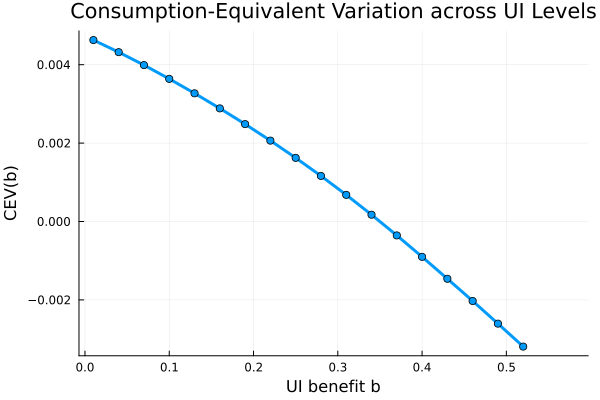

In [37]:
b      = b_simul_2[:, 1]
cev    = b_simul_2[:, 2]

plot(
    b, cev,
    xlabel = "UI benefit b",
    ylabel = "CEV(b)",
    title  = "Consumption-Equivalent Variation across UI Levels",
    legend = false,
    lw = 3,
    marker = :circle
)


**Garbage**

In [ ]:
function main()

    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);

    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




    # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        # @printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end


    # initial prices
    rrate    = 0.040237086402090;
    wagerate = getwage(rrate);


    # GUESS:: initializing value function (inceasing in k) and initial derivative
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = getlevel(igrid-1)
                valueF[igrid, iprod, iemplo] = utility(wagerate*sstates[iprod]*(emplo[iemplo] + b*(1-emplo[iemplo]))*(1-tau_wage) + (1+rrate)*a)
            end
        end
    end

    # GUESS initial distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed

    
    ## COMPUTE derivative
    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)

                # interior deriv
                if (igrid>=3)
                    dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                end

                # left corner
                dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);
                # right corner
                dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);

            end
        end
    end 

    POLICY_we(valueF,dvalueF,save,wagerate,rrate,grid);
            
    capitalout, laborout=SIMULATION_we(save,dist,grid);


    distI = zeros(Float64, size_k);

    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)
                distI[igrid] += dist[igrid,iprod, iemplo];
            end
        end
    end 

    ##display(plot(save,dist,xlimits=(0,50)))
    ##display(plot(grid,distI,xlimits=(0,50)))
    
end

main();*